# DCGAN with Pytorch

### 데이터셋 로딩 및 준비

/home/zendo/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


device: cuda:0


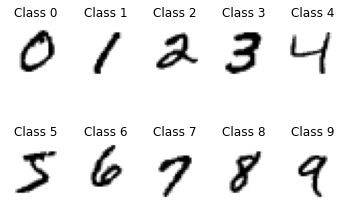

In [1]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline

# define nz(size of noise), batch_size
nz = 100
batch_size = 128

# MNIST training data
train_set = dset.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)

# MNIST testing data
test_set = dset.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor())

# Create the dataloader
dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:",device)



# Plot some sample training images
for c in range(10):
    i = 0
    while True:
        if train_set.targets[i] == c:
            plt.subplot(2, 5, c+1)
            plt.axis('off')
            plt.imshow(train_set.data[i], cmap="gray_r")
            plt.title('Class %d' % c)
            break
        i += 1

## 모델 만들기

#### weight 초기화

In [2]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### 생성자(generator)

In [3]:
class Generator(nn.Module):
    def __init__(self, nc, nz, ngf):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # state size. 100 x 1 x 1
            nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(inplace=True),
            # state size. 256 x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(inplace=True),
            # state size. 128 x 7 x 7
            nn.ConvTranspose2d(ngf * 2, ngf, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(inplace=True),
            # state size. 64 x 14 x 14
            nn.ConvTranspose2d(ngf, 1, 4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # state size. 1 x 28 x 28
        )
    
    def forward(self, input):
        # reshape input into (100 x 1 x 1)
        x = input.view(-1, nz, 1, 1)
        x = self.model(x)
        return x

생성자를 이용한 이미지 생성.

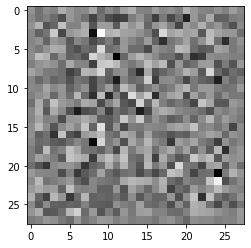

In [4]:
generator = Generator(1, nz, 64).to(device)

generator.apply(weights_init)

noise = torch.randn((1,nz)).to(device)
generated_image = generator(noise)

plt.imshow(generated_image[0,0,:,:].cpu().detach(), cmap='gray_r')

### 감별자(discriminator)

In [5]:
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # input is 1 x 28 x 28
            nn.Conv2d(nc, ndf, 4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(inplace=True),
            # state size. 64 x 14 x 14
            nn.Conv2d(ndf, ndf * 2, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(inplace=True),
            # state size. 128 x 7 x 7
            nn.Conv2d(ndf * 2, ndf * 4, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(inplace=True),
            # state size. 256 x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        return self.model(input).view(-1, 1).squeeze(1)

감별자를 이용한 이미지 분류. 진짜 이미지라면 1에 가까운 값을, 가짜 이미지라면 0에 가까운 값을 출력한다.

In [6]:
discriminator = Discriminator(1, 64).to(device)
discriminator.apply(weights_init)

decision = discriminator(generated_image)
print(decision)

tensor([0.5301], device='cuda:0', grad_fn=<SqueezeBackward1>)


### 손실함수와 optimizer

In [7]:
cross_entropy = nn.BCELoss()

#### 감별자 손실함수

In [8]:
def discriminator_loss(real_output, fake_output):
    bs = real_output.size(0)
    real_loss = cross_entropy(real_output, torch.full((bs,), 1.0, device=device))
    fake_loss = cross_entropy(fake_output, torch.full((bs,), 0.0, device=device))
    return real_loss + fake_loss

#### 생성자 손실함수

In [9]:
def generator_loss(fake_output):
    bs = fake_output.size(0)
    return cross_entropy(fake_output, torch.full((bs,), 1.0, device=device))

#### optimizer

In [10]:
generator_optim = torch.optim.Adam(generator.parameters(), 1e-4, betas=(0.9,0.999))
discriminator_optim = torch.optim.Adam(discriminator.parameters(), 1e-4, betas=(0.9,0.999))

## 훈련

In [11]:
num_epochs = 100
noise_dim = 100
num_examples_to_generate = 16

img_list = []
G_losses = []
D_losses = []

seed = torch.randn(num_examples_to_generate, noise_dim, device=device)

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        ## Discriminator part ##
        # train with all-real batch
        discriminator.zero_grad()
        real = data[0].to(device)
        # forward pass real batch through discriminator
        real_output = discriminator(real).view(-1)
        # train with all-fake batch
        noise = torch.randn(real_output.size(0), nz, device=device)
        fake = generator(noise)
        # forward pass fake batch through discriminator
        fake_output = discriminator(fake.detach()).view(-1)
        # calculate gradient in backward pass
        d_loss = discriminator_loss(real_output, fake_output)
        d_loss.backward()
        # update discrminator
        discriminator_optim.step()
        
        ## Generator part ##
        generator.zero_grad()
        # forward pass fake batch through discriminator
        fake_output = discriminator(fake).view(-1)
        # calculate gradient in backward pass
        g_loss = generator_loss(fake_output)
        g_loss.backward()
        # update generator
        generator_optim.step()
        
        if i == len(dataloader)-1:
            # pring training status
            print('[%3d/%d]\td_loss: %.4f\tg_loss: %.4f'
                  %(epoch+1, num_epochs ,d_loss.item(),g_loss.item()))
            # save losses for later plot
            G_losses.append(g_loss.item())
            D_losses.append(d_loss.item())
        
            # check how the generator is doing by saving generator's output on seed
            with torch.no_grad():
                fake = generator(seed).detach().cpu().view(-1,1,28,28)
            img_list.append(vutils.make_grid(fake, nrow=4, padding=2, normalize=True))

[  1/100]	d_loss: 0.0048	g_loss: 7.2487
[  2/100]	d_loss: 0.0128	g_loss: 6.9724
[  3/100]	d_loss: 0.0114	g_loss: 8.2498
[  4/100]	d_loss: 0.0016	g_loss: 7.6699
[  5/100]	d_loss: 0.0037	g_loss: 7.5961
[  6/100]	d_loss: 0.0032	g_loss: 6.7716
[  7/100]	d_loss: 0.0235	g_loss: 7.0927
[  8/100]	d_loss: 0.0028	g_loss: 8.0921
[  9/100]	d_loss: 0.0105	g_loss: 5.8306
[ 10/100]	d_loss: 0.0067	g_loss: 7.0564
[ 11/100]	d_loss: 0.0213	g_loss: 6.2587
[ 12/100]	d_loss: 0.0134	g_loss: 4.9508
[ 13/100]	d_loss: 0.0078	g_loss: 6.4496
[ 14/100]	d_loss: 0.0361	g_loss: 4.9858
[ 15/100]	d_loss: 0.1518	g_loss: 3.0718
[ 16/100]	d_loss: 0.0167	g_loss: 6.9600
[ 17/100]	d_loss: 0.0337	g_loss: 5.1433
[ 18/100]	d_loss: 0.0074	g_loss: 7.3098
[ 19/100]	d_loss: 0.0178	g_loss: 6.2282
[ 20/100]	d_loss: 0.0251	g_loss: 4.9362
[ 21/100]	d_loss: 0.0957	g_loss: 4.9348
[ 22/100]	d_loss: 0.2312	g_loss: 7.2405
[ 23/100]	d_loss: 0.0116	g_loss: 4.5831
[ 24/100]	d_loss: 0.0434	g_loss: 5.3443
[ 25/100]	d_loss: 0.0158	g_loss: 5.7755


### 훈련의 결과

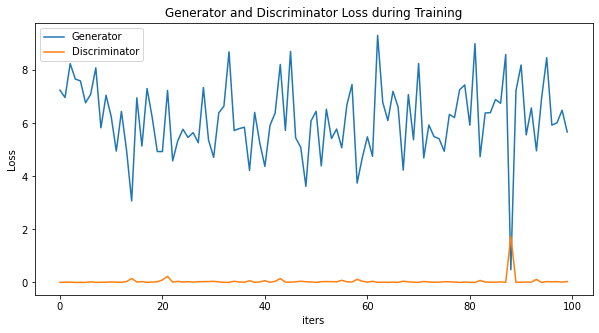

In [12]:
plt.figure(figsize=(10,5))
plt.title('Generator and Discriminator Loss during Training')
plt.plot(G_losses, label='Generator')
plt.plot(D_losses, label='Discriminator')
plt.xlabel("iters")
plt.ylabel("Loss")
plt.legend()
plt.show()

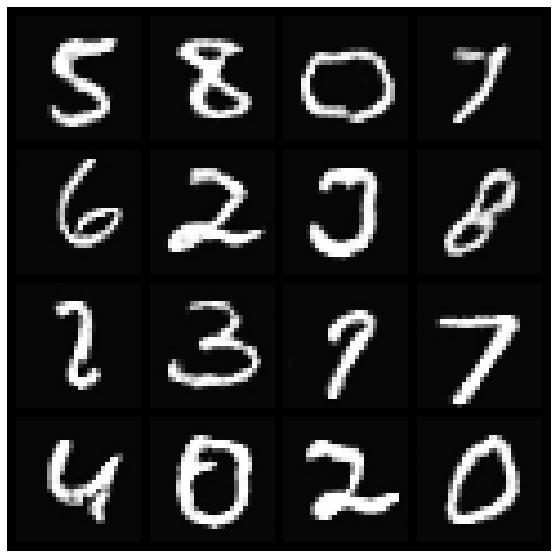

In [14]:
fig = plt.figure(figsize=(10,10))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=100)
HTML(ani.to_jshtml())